# Correct use of Jittering
This tutorial discusses the background and correct use of the jittering/dithering method implemented in the package.

In [5]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

import sed
from sed.dataset import dataset

%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [6]:
# dataset.get("WSe2") # Put in Path to a storage of at least 20 Gbyte free space.
# data_path = dataset.dir # This is the path to the data
# scandir, _ = dataset.subdirs # scandir contains the data, _ contains the calibration files
scandir = "/Users/zain/Documents/Work/sed_fresh_copy/sed/tutorial/datasets/WSe2/Scan049_1"

In [7]:
# create sed processor using the config file:
sp = sed.SedProcessor(folder=scandir, config="../sed/config/mpes_example_config.yaml")

Configuration loaded from: [/Users/zain/Documents/Work/sed_fresh_copy/sed/docs/sed/config/mpes_example_config.yaml]
Default config loaded from: [/Users/zain/Documents/Work/sed_fresh_copy/sed/sed/config/default.yaml]


After loading, the dataframe contains the four columns `X`, `Y`, `t`, `ADC`, which have all integer values. They originate from a time-to-digital converter, and correspond to digital "bins".

In [8]:
sp.dataframe.head()

,X,Y,t,ADC
0,0.0,0.0,0.0,0.0
1,365.0,1002.0,70101.0,6317.0
2,761.0,818.0,75615.0,6316.0
3,692.0,971.0,66455.0,6317.0
4,671.0,712.0,73026.0,6317.0


Let's bin these data along the `t` dimension within a small range:

  0%|          | 0/3 [00:00<?, ?it/s]

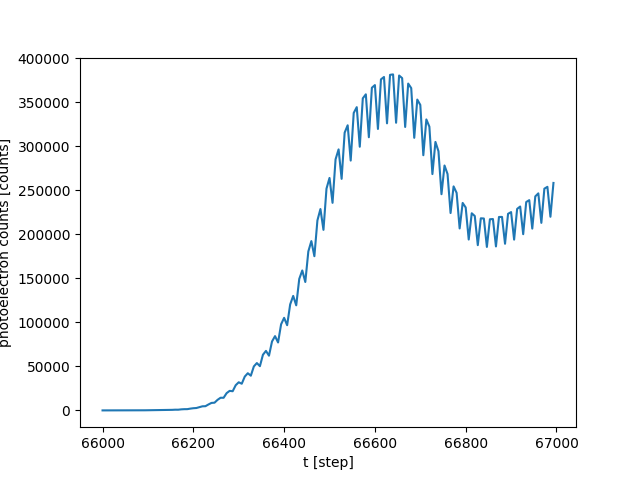

In [9]:
axes = ['t']
bins = [150]
ranges = [[66000, 67000]]
res01 = sp.compute(bins=bins, axes=axes, ranges=ranges, df_partitions=20)
plt.figure()
res01.plot()

We notice some oscillation ontop of the data. These are re-binning artefacts, originating from a non-integer number of machine-bins per bin, as we can verify by binning with a different number of steps:

  0%|          | 0/3 [00:00<?, ?it/s]

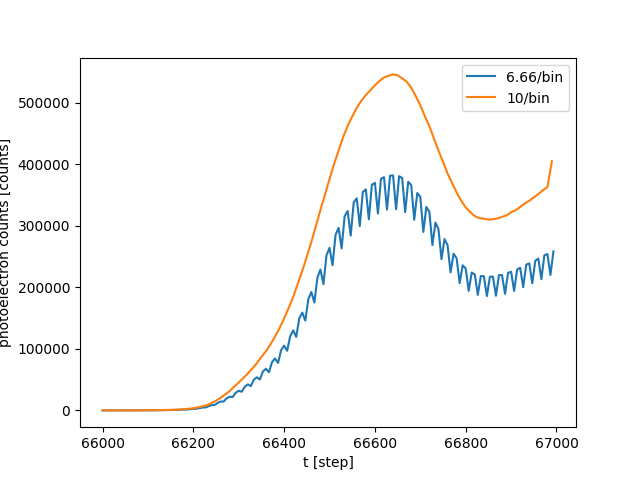

In [10]:
axes = ['t']
bins = [100]
ranges = [[66000, 67000]]
res02 = sp.compute(bins=bins, axes=axes, ranges=ranges, df_partitions=20)
plt.figure()
res01.plot(label="6.66/bin")
res02.plot(label="10/bin")
plt.legend()

If we have a very detailed look, with step-sizes smaller than one, we see the digital nature of the original data behind this issue:

  0%|          | 0/3 [00:00<?, ?it/s]

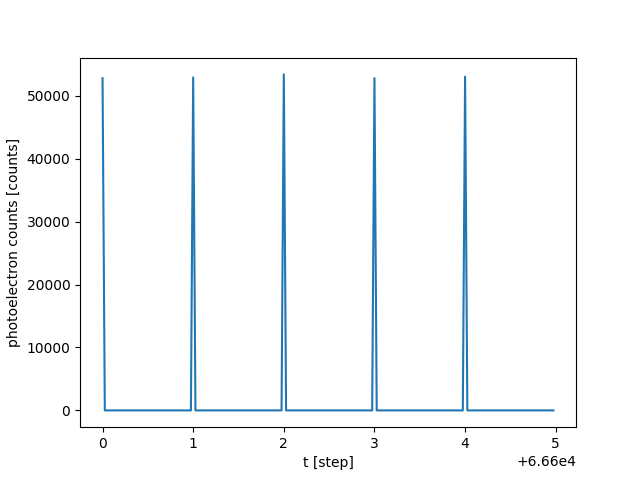

In [11]:
axes = ['t']
bins = [200]
ranges = [[66600, 66605]]
res11 = sp.compute(bins=bins, axes=axes, ranges=ranges, df_partitions=20)
plt.figure()
res11.plot()

To mitigate this problem, we can add some randomness to the data, and re-distribute events into the gaps in-between bins. This is also termed `dithering` and e.g. known from image manipulation. The important factor is to add the right amount and right type of random distribution, to end up at a quasi-continous uniform distribution, but not lose information.

We can use the add_jitter function for this. We can pass it the colums to add jitter to, and the amplitude of a uniform jitter. Importantly, this step should be taken in the very beginning as first step before any dataframe operations are added.

Let's try with a value of 0.2 for the amplitude:

In [12]:
df_backup = sp.dataframe
sp.add_jitter(cols=["t"], amps=[0.2])

We see that the `t` column is no longer integer-valued:

In [13]:
sp.dataframe.head()

,X,Y,t,ADC
0,0.0,0.0,0.104611,0.0
1,365.0,1002.0,70100.874337,6317.0
2,761.0,818.0,75615.165538,6316.0
3,692.0,971.0,66454.918564,6317.0
4,671.0,712.0,73025.951131,6317.0


  0%|          | 0/3 [00:00<?, ?it/s]

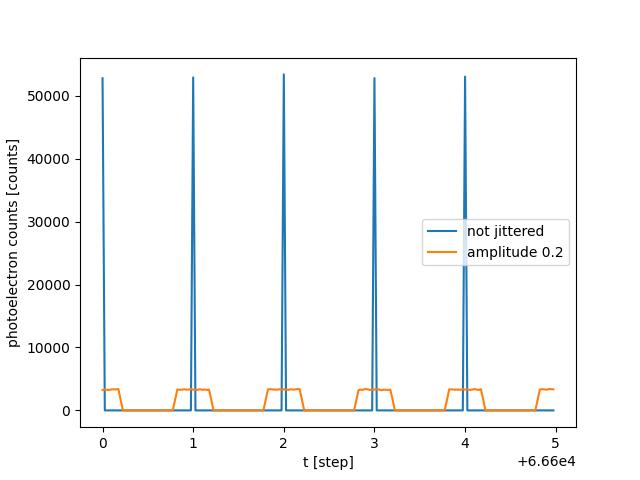

In [15]:
axes = ['t']
bins = [200]
ranges = [[66600, 66605]]
res12 = sp.compute(bins=bins, axes=axes, ranges=ranges, df_partitions=20)
plt.figure()
res11.plot(label="not jittered")
res12.plot(label="amplitude 0.2")
plt.legend()

This is clearly not enough jitter to close the gaps. The ideal (and default) amplitude is 0.5, which exactly fills the gaps:

In [16]:
sp.dataframe = df_backup
sp.add_jitter(cols=["t"], amps=[0.5])

  0%|          | 0/3 [00:00<?, ?it/s]

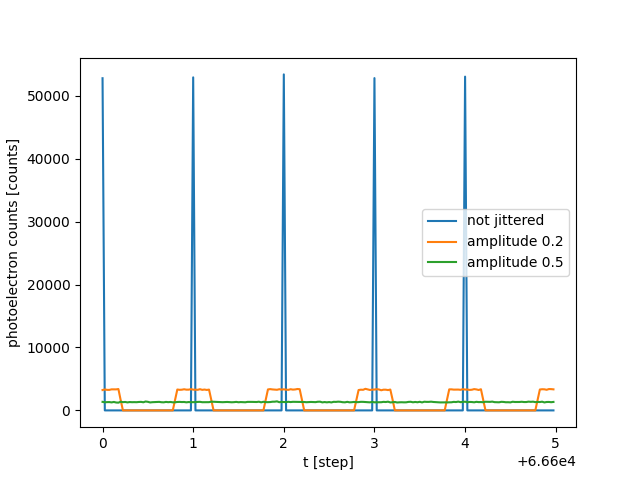

In [17]:
axes = ['t']
bins = [200]
ranges = [[66600, 66605]]
res13 = sp.compute(bins=bins, axes=axes, ranges=ranges, df_partitions=20)
plt.figure()
res11.plot(label="not jittered")
res12.plot(label="amplitude 0.2")
res13.plot(label="amplitude 0.5")
plt.legend()

This jittering fills the gaps, and produces a continous uniform distribution. Let's check again the longer-range binning that gave us the oscillations initially:

  0%|          | 0/3 [00:00<?, ?it/s]

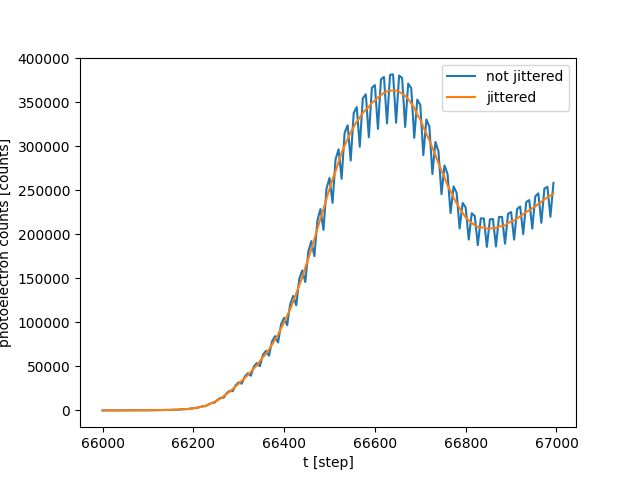

In [18]:
axes = ['t']
bins = [150]
ranges = [[66000, 67000]]
res03 = sp.compute(bins=bins, axes=axes, ranges=ranges, df_partitions=20)
plt.figure()
res01.plot(label="not jittered")
res03.plot(label="jittered")
plt.legend()

Now, the artefacts are absent, and similarly will they be in any dataframe columns derived from a column jittered in such a way. Note that this only applies to data present in digital (i.e. machine-binned) format, and not to data that are intrinsically continous. 

Also note that too large or not well-aligned jittering amplitudes will
- deteriorate your resolution along the jittered axis
- will not solve the problem entirely:

In [19]:
sp.dataframe = df_backup
sp.add_jitter(cols=["t"], amps=[0.7])

  0%|          | 0/3 [00:00<?, ?it/s]

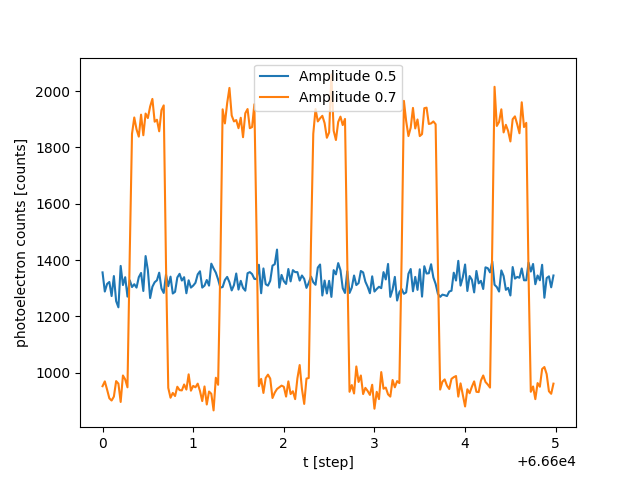

In [20]:
axes = ['t']
bins = [200]
ranges = [[66600, 66605]]
res14 = sp.compute(bins=bins, axes=axes, ranges=ranges, df_partitions=20)
plt.figure()
res13.plot(label="Amplitude 0.5")
res14.plot(label="Amplitude 0.7")
plt.legend()

If the step-size of digitization is different from 1, the corresponding stepssize (half the distance between digitized values) can be adjusted as shown above.

Also, alternatively also normally distributed noise can be added, which is less sensitive to the exact right amplitude, but will lead to mixing of neighboring voxels, and thus loss of resolution. Also, normally distributed noise is substantially more computation-intensive to generate. It can nevertheless be helpful in situations where e.g. the stepsize is non-uniform.

In [21]:
sp.dataframe = df_backup
sp.add_jitter(cols=["t"], amps=[0.7], jitter_type="normal")

  0%|          | 0/3 [00:00<?, ?it/s]

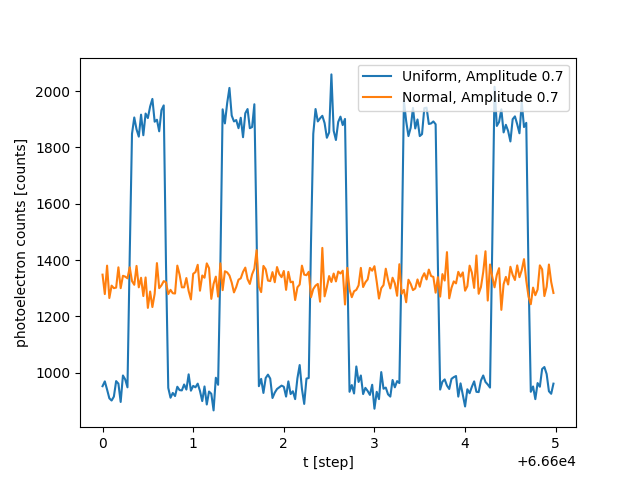

In [22]:
axes = ['t']
bins = [200]
ranges = [[66600, 66605]]
res15 = sp.compute(bins=bins, axes=axes, ranges=ranges, df_partitions=20)
plt.figure()
res14.plot(label="Uniform, Amplitude 0.7")
res15.plot(label="Normal, Amplitude 0.7")
plt.legend()